In [60]:
import pandas as pd
import folium
# import sys
# sys.path.insert(1,'/Users/matthewhwang/projects/covid-19-data')
import os
import branca
import json
import requests
import math

from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
import folium
from folium.plugins import TimestampedGeoJson

import copy

geo_counties_json = os.path.join('data','gz_2010_us_050_00_20m.json')
geo_states_json = os.path.join('data','gz_2010_us_040_00_20m.json')

# Gather Data from Separate Repo
Refresh data from source repo <br>
`git fetch --all`<br>
`git reset --hard origin/master`

## Import data into dataframes

In [61]:
data_path = '/Users/matthewhwang/projects/covid-19-data/'
county_data = pd.read_csv(data_path+'us-counties.csv')
state_data = pd.read_csv(data_path+'us-states.csv')
county_data = county_data.dropna()
state_data = state_data.dropna()

In [62]:
# Clean up State Data for ones that don't have Geo Data
remove = ["District of Columbia","Puerto Rico","Virgin Islands","Northern Mariana Islands","Guam"]
state_data = state_data[-state_data.state.isin(remove)]

## Import US Geography JSON Files

In [63]:
with open(geo_counties_json,encoding = "ISO-8859-1") as file:
    county_geo = json.load(file)
with open(geo_states_json) as file:
    state_geo = json.load(file)

In [64]:
# Sample County Geometry
# Use FIPS code as last 5 digits of GEO_ID
county_geo['features'][0]

{'type': 'Feature',
 'properties': {'GEO_ID': '0500000US01001',
  'STATE': '01',
  'COUNTY': '001',
  'NAME': 'Autauga',
  'LSAD': 'County',
  'CENSUSAREA': 594.436},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-86.496774, 32.344437],
    [-86.717897, 32.402814],
    [-86.814912, 32.340803],
    [-86.890581, 32.502974],
    [-86.917595, 32.664169],
    [-86.71339, 32.661732],
    [-86.714219, 32.705694],
    [-86.413116, 32.707386],
    [-86.411172, 32.409937],
    [-86.496774, 32.344437]]]}}

In [65]:
# Sample State Geometry
state_geo['features'][0]

{'type': 'Feature',
 'properties': {'GEO_ID': '0400000US04',
  'STATE': '04',
  'NAME': 'Arizona',
  'LSAD': '',
  'CENSUSAREA': 113594.084},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-112.538593, 37.000674],
    [-112.534545, 37.000684],
    [-112.368946, 37.001125],
    [-112.35769, 37.001025],
    [-111.412784, 37.001478],
    [-111.405869, 37.001481],
    [-111.405517, 37.001497],
    [-111.189888, 37.000959],
    [-110.75069, 37.003197],
    [-110.495259, 37.003875],
    [-110.33105, 36.998216],
    [-110.000677, 36.997968],
    [-109.381226, 36.999148],
    [-109.378039, 36.999135],
    [-109.270097, 36.999266],
    [-109.268213, 36.999242],
    [-109.26339, 36.999263],
    [-109.246917, 36.999346],
    [-109.233848, 36.999266],
    [-109.181196, 36.999271],
    [-109.045223, 36.999084],
    [-109.045244, 36.969489],
    [-109.045272, 36.968871],
    [-109.045407, 36.874998],
    [-109.045433, 36.874589],
    [-109.045973, 36.002338],
    [-109.046011, 35.925896],
    

## Define Bin Sizes

In [78]:
# Equally spaced bins based on number of cases
bin_edges_states = np.linspace(0,state_data.cases.max(),50)
bin_edges_counties = np.linspace(0,county_data.cases.max(),50)

# Could do it on logarithmic scale or other method to increase / decrease "severity coloring"
# Potentially in line with county population density or based on rate of increase of cases / deaths
# Death rate based on age of population + density

## Define Color Scale
Used this tool: <br>
https://gka.github.io/palettes/#/0|s|94003a|ffffe0,ff005e,93003a|1|1

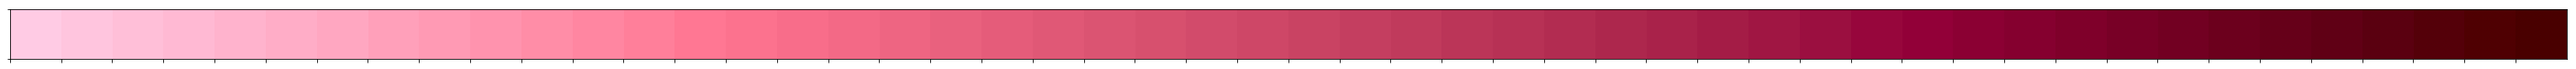

In [79]:
fifty_color_red = ['#490000', '#4f0002', '#540009', '#5a0010', '#600015', '#660019', '#6c001d', '#720022', '#780026', '#7f002a', '#85002f', '#8b0033', '#920038', '#97063c', '#9b0f40', '#a01643', '#a41c46', '#a9224a', '#ad274d', '#b22c51', '#b73155', '#bb3558', '#c03a5c', '#c43e60', '#c94363', '#ce4767', '#d24b6b', '#d7506e', '#db5472', '#e05876', '#e55c7a', '#e9617e', '#ee6582', '#f36986', '#f86d8a', '#fc728e', '#ff7793', '#ff7f9a', '#ff86a1', '#ff8da7', '#ff93ae', '#ff9ab4', '#ffa0ba', '#ffa7c1', '#ffadc7', '#ffb3cd', '#ffb9d3', '#ffbfd8', '#ffc5de', '#ffcbe4']
fifty_color_red.reverse()
color_scale = np.array(fifty_color_red)
sns.palplot(sns.color_palette(color_scale))

In [80]:
def color_coding(value, bin_edges):  
    # Returns color based on where value lies in the provided bin
    idx = np.digitize(value, bin_edges, right=True)
    return color_scale[idx]


## Generate Color based on row value

In [81]:
state_data['color'] = state_data['cases'].apply(lambda x: color_coding(x,bin_edges_states))
county_data['color'] = county_data['cases'].apply(lambda x: color_coding(x,bin_edges_counties))

## Adjust fips from float to int and fix leading zero issue

In [98]:
county_data.fips = county_data.fips.apply(lambda x: '0'+ str(int(x)) if len(str(x))< 6 else str(int(x)))
state_data.fips = state_data.fips.apply(lambda x: '0' + str(int(x)) if len(str(x)) == 1 else str(int(x)))

In [99]:
county_data.head()

,date,county,state,fips,cases,deaths,color
0,2020-01-21,Snohomish,Washington,53061,1,0,#ffc5de
1,2020-01-22,Snohomish,Washington,53061,1,0,#ffc5de
2,2020-01-23,Snohomish,Washington,53061,1,0,#ffc5de
3,2020-01-24,Cook,Illinois,17031,1,0,#ffc5de
4,2020-01-24,Snohomish,Washington,53061,1,0,#ffc5de


## Make GeoJSON Lookup Dict

Potentially a index by method versus making a new cache, but this will suffice for now

In [115]:
# COUNTY
counties = county_geo['features']
counties_geo_dict = {}
for each in counties:
    counties_geo_dict[each['properties']['GEO_ID'][-5:]] = each
    
# STATE
state = state_geo['features']
states_geo_dict = {}
for each in state:
    states_geo_dict[each['properties']['STATE']] = each
    

In [104]:
# States Feature List Generation
def create_geojson_features_modded(df,geo_dict):
    print('> Creating GeoJSON features...')
    features = []
    for _, row in df.iterrows():
        feature = {}
        feature = geo_dict[row.fips]
        feature['properties']['time'] = row.date
        feature['properties']['cases'] = row.cases
        feature['properties']['style'] = {'fillColor':row['color'],'fillOpacity': 0.75,'weight':0.5}
        test = copy.deepcopy(feature)
        features.append(test)
    print("COMPLETED")
    return features

In [116]:
states_feature = create_geojson_features_modded(state_data,states_geo_dict)

> Creating GeoJSON features...
COMPLETED


In [110]:
counties_feature = create_geojson_features_modded(county_data,counties_geo_dict)

> Creating GeoJSON features...
COMPLETED


In [111]:
def make_map(features):
    print('> Making map...')
    start=[48, -102]
    USA_map = folium.Map(location=start, control_scale=True, zoom_start=5)

    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': a}
        , period='P1D'
        , duration='P1D'
        , add_last_point=False
        , auto_play=False
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY-MM-DD'
        , time_slider_drag_update=True
    ).add_to(USA_map)
    print('> Done.')
    return USA_map


In [119]:
counties_map = make_map(counties_feature)

> Making map...
> Done.


In [120]:
counties_map.save('COVID_COUNTIES_USA.html')

In [128]:
state_map = make_map(states_feature)

> Making map...
> Done.


In [129]:
state_map.save('COVID_STATES_USA.html')

In [124]:
state_data.head()

,date,state,fips,cases,deaths,color
0,2020-01-21,Washington,53,1,0,#ffc5de
1,2020-01-22,Washington,53,1,0,#ffc5de
2,2020-01-23,Washington,53,1,0,#ffc5de
3,2020-01-24,Illinois,17,1,0,#ffc5de
4,2020-01-24,Washington,53,1,0,#ffc5de


In [126]:
states_feature[0]

{'type': 'Feature',
 'properties': {'GEO_ID': '0400000US53',
  'STATE': '53',
  'NAME': 'Washington',
  'LSAD': '',
  'CENSUSAREA': 66455.521,
  'time': '2020-01-21',
  'cases': 1,
  'style': {'fillColor': '#ffc5de', 'fillOpacity': 0.75, 'weight': 0.5}},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-122.397349, 47.912401],
     [-122.419274, 47.912125],
     [-122.431035, 47.914732],
     [-122.445519, 47.930226],
     [-122.445759, 47.93619],
     [-122.44079, 47.946594],
     [-122.44076, 47.951845],
     [-122.446682, 47.963155],
     [-122.47266, 47.988449],
     [-122.487505, 47.990729],
     [-122.501257, 47.987089],
     [-122.514813, 47.981152],
     [-122.51778, 47.974916],
     [-122.521219, 47.972997],
     [-122.546824, 47.967215],
     [-122.552053, 47.973644],
     [-122.551032, 47.977346],
     [-122.543063, 47.985983],
     [-122.541564, 47.992998],
     [-122.542924, 47.996404],
     [-122.560018, 48.006502],
     [-122.58178, 48.010386],
     [-122.60734

In [127]:
counties_feature[0]

{'type': 'Feature',
 'properties': {'GEO_ID': '0500000US53061',
  'STATE': '53',
  'COUNTY': '061',
  'NAME': 'Snohomish',
  'LSAD': 'County',
  'CENSUSAREA': 2087.273,
  'time': '2020-01-21',
  'cases': 1,
  'style': {'fillColor': '#ffc5de', 'fillOpacity': 0.75, 'weight': 0.5}},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-122.321721, 48.019977],
     [-122.303455, 48.005603],
     [-122.306629, 48.004397],
     [-122.326115, 48.010295],
     [-122.334524, 48.018916],
     [-122.328343, 48.021335],
     [-122.321721, 48.019977]]],
   [[[-121.584537, 47.776726],
     [-121.928146, 47.776971],
     [-122.000396, 47.775284],
     [-122.000425, 47.775284],
     [-122.396422, 47.777927],
     [-122.397043, 47.779719],
     [-122.394944, 47.803318],
     [-122.392044, 47.807718],
     [-122.353244, 47.840618],
     [-122.346544, 47.842418],
     [-122.339944, 47.846718],
     [-122.33595, 47.852306],
     [-122.329545, 47.869418],
     [-122.330145, 47.875318],
     [-122.333